# LGBM을 활용한 베이스라인

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
import os
import random

## 1. 데이터 로딩

In [2]:
data_dir = '/opt/ml/input/data' # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
df = pd.read_csv(csv_file_path)
df[:3]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225


## 2. Feature Engineering

In [3]:
def feature_engineering(df):
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    return df

### 2.1 이해해보기

In [ ]:
df.sort_values(by=['userID','Timestamp'], inplace=True)

In [ ]:
## 유저별 맞춘 개수를 한칸 아래로 땡기기(shift 1)
df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
## 유저별 문제 푼 개수 cumcount
df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
# 유저별 푼 문제수에 따른 정확도
df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

In [ ]:
df[df.userID==7441]

In [ ]:
# testId와 KnowledgeTag의 전체 정답률은 한번에 계산
# 아래 데이터는 제출용 데이터셋에 대해서도 재사용

## 시험지별 정답률과 맞춘 횟수
correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
correct_t.columns = ["test_mean", 'test_sum']
## 문제 유형별 정답률과 맞춘 횟수
correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
correct_k.columns = ["tag_mean", 'tag_sum']

In [ ]:
correct_t[:3]
correct_k[:3]

In [ ]:
## df에 시험지별 정답률과 맞춘 횟수 추가
df = pd.merge(df, correct_t, on=['testId'], how="left")
## df에 문제 유형별 정답률과 맞춘 횟수 추가
df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")

In [ ]:
df[:3]

In [4]:
df = feature_engineering(df)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0.947683,1268,0.955022,637
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.0,0.947683,1268,0.913187,3040
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.0,0.947683,1268,0.913187,3040
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.0,0.947683,1268,0.913187,3040
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.0,0.947683,1268,0.913187,3040


## 3. Train/Test 데이터 셋 분리

In [5]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    ## (user_id, 문제푼 횟수)를 원소로 갖는 리스트
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users) # 셔플
    
    max_train_data_len = ratio*len(df) # train data 길이
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users: # for문으로 전체의 ratio 퍼센트만 user_ids에 추가
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)

    ## train, test split
    train = df[df['userID'].isin(user_ids)] # train
    test = df[df['userID'].isin(user_ids) == False] # test

    #test데이터셋은, train에서 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [6]:
df.shape

(2266586, 13)

In [7]:
df[:3]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0.947683,1268,0.955022,637
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.0,0.947683,1268,0.913187,3040
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.0,0.947683,1268,0.913187,3040


### 3.1 이해해보기

In [7]:
## (user_id, 문제푼 횟수)를 원소로 갖는 리스트
list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))[:3]

[(730, 1860), (481, 1847), (1112, 1777)]

In [8]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum']

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [9]:
#test데이터셋은, train에서 각 유저의 마지막 interaction만 추출
test[test['userID'] != test['userID'].shift(-1)][:3]

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
744,0,A080129006,A080000129,2020-12-23 03:40:19,2725,470.0,744,0.631720,0.360111,780,0.301939,436
2786,5,A080138007,A080000138,2020-12-11 22:48:28,8431,662.0,832,0.795673,0.504405,916,0.491346,511
3707,6,A030145005,A030000145,2020-10-26 09:52:14,7817,408.0,920,0.443478,0.628679,833,0.617073,2530


In [10]:
train.shape, test.shape

((1586157, 12), (2007, 12))

In [11]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [12]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

In [11]:
model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=500,
    early_stopping_rounds=100
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

/Users/cwj/miniconda3/envs/tf25/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/cwj/miniconda3/envs/tf25/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1039565, number of negative: 546592
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2031
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655399 -> initscore=0.642855
[LightGBM] [Info] Start training from score 0.642855
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.559427	valid_1's binary_logloss: 0.681014
[200]	training's binary_logloss: 0.556528	valid_1's binary_logloss: 0.680677
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.558699	valid_1's binary_logloss: 0.680181
VALID AUC : 0.6904581594116477 ACC : 0.6098654708520179



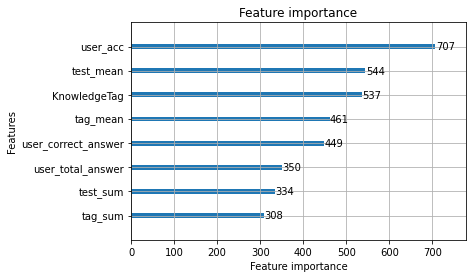

In [12]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 5. Inference

In [13]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [14]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [15]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/submission.csv


14

21

21

21

21

21

21

21

20

21

20

22

22

22

22

20

22

23

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

22

21

22

22

22

22

22

23

22

23

23

22

22

23

22

22

22

22

22

23

22

21

22

21

22

22

22

22

22

22

21

23

22

22

23

22

22

22

22

23

22

22

22

22

22

22

22

22

22

22

21

23

22

22

22

22

23

23

22

22

21

22

23

22

22

22

23

22

23

24

23

23

23

23

23

23

23

23

23

24

24

23

23

23

24

24

23

23

23

23

23

23

23

24

23

23

22

23

23

23

23

22

23

23

23

23

23

23

23

23

23

23

23

23

24

23

24

24

22

23

22

23

23

23

23

23

23

23

23

23

22

23

23

24

23

23

23

23

23

23

24

23

23

23

24

23

23

23

23

23

23

22

23

23

23

23

23

23

23

23

23

23

23

23

23

22

23

22

24

23

23

23

21

23

23

23

23

24

23

23

23

23

23

23

23

23

23

23

24

23

23

23

23

23

24

24

23

22

23

24

23

23

24

23

23

23

23

23

23

23

23

24

24

23

23

23

24

23

23

23

23

24

23

23

22

24

23

23

23

24

23

23

23

23

22

23

24

23

23

23

23

23

23

23

22

23

23

22

23

23

23

23

23

23

23

23

23

23

23

23

23

23

23

23

23

23

23

23

22

23

23

24

23

23

23

23

23

23

22

22

23

23

23

22

24

23

24

23

23

24

22

24

22

24

23

23

23

24

23

23

23

23

24

23

23

23

23

23

23

23

23

23

23

23

23

23

23

23

23

23

23

23

22

23

23

22

23

23

24

24

23

23

23

23

23

23

23

23

23

23

23

23

24

22

23

23

24

21

23

23

23

24

23

23

23

23

24

23

23

23

23

23

23

23

24

23

23

22

23

24

23

23

23

24

24

23

23

24

24

23

24

23

23

23

22

23

23

23

23

23

23

23

23

23

23

23

22

23

23

23

23

22

23

24

23

23

23

23

23

23

23

23

23

23

23

23

23

23

23

24

24

23

23

23

23

23

22

23

24

23

23

23

23

23

24

23

23

23

23

24

23

24

23

23

23

23

23

23

22

24

23

23

23

23

24

23

23

23

23

24

24

23

23

24

24

23

23

23

22

23

23

24

23

22

23

24

23

24

23

23

23

23

23

23

23

23

23

23

23

24

23

23

23

23

22

23

23

24

24

23

23

23

22

23

23

23

23

23

23

23

22

22

23

23

23

23

23

24

23

23

24

22

23

23

23

23

23

23

23

22

23

23

23

23

23

24

24

23

24

23

24

23

24

23

23

23

23

23

23

23

23

23

24

23

23

23

24

22

22

23

23

23

23

22

23

24

23

22

23

23

23

23

23

23

24

23

23

22

23

23

22

23

23

23

22

21

23

24

22

23

23

23

23

23

24

23

23

22

23

23

23

23

23

24

23

21

23

23

23

23

23

23

24

23

23

23

22

23

23

23

23

23

22

23

24

23

23

23

23

24

23

23

23

23

23

23

23

24

23

23

23

23

24

23

23

24

23

23

23

22

23

23

23

23

23

23

24

23

23

23

24

24

23

24

23

23

23

22

23

23

23

23

23

23

24

23

23

24

23

23

23

23

23

23

24

23

23

23

23

22

23

23

24

23

23

23

23

23

23

23

23

23

23

23

23

23

23

23

23

23

In [17]:
!open output

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

